In [1]:
import pandas as pd
import re
import string
import numpy as np
import matplotlib.pyplot as plt

# Homework 2

**Mert Ketenci**   
**mk4139**

## Problem 1

For this problem, we are going to derive and implement non-negative matrix factorization (NMF) as in "Learning the parts of objects by non-negative matrix factorization" (Lee and Seung, 1999). We are first going to underline the generative process of the model. Draw the graphical model, derive the update rules mathematically and implement the algorithm.

#### The Generative Process:

For $i \in [1,....n]$   
$\;\;\;$ Draw component $\vec{W_{i}}$   
For $j \in [1,....m]$   
$\;\;\;$ Draw component $\vec{H_{j}}$   
For $ i \in [1,....n]$   
$\;\;\;$ For $ j \in [1,....m]$   
$\;\;\;\;\;\;$ Draw $V_{ij} \sim Poi(\vec{W_{i}}\vec{H_{j}})$

Note that $\vec{W_{i}}$ is a row and $\vec{H_{j}}$ is a column vector.

#### The Graphical Model:

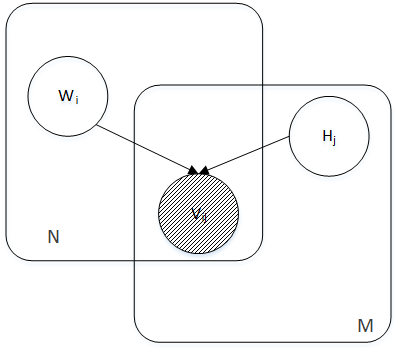

See that, the paper did not put any distribution on vectors $\vec{W_{i}}$ and $\vec{H_{j}}$. By adding a **Laplace/Normal** distribution we can convert the above model into NFM with **L1/L2** regularization. For now, we are going to stick to the original paper.

### Derivation of Updates:

In this section, we are going to derive coordinate descent updates for the NFM algorithm.

$$P(V,W,H) = \prod_{i}\prod_{j}\frac{e^{-\vec{W_{i}}\vec{H_{j}}}\left(\vec{W_{i}}\vec{H_{j}}\right)^{V_{ij}}}{V_{ij}!}$$

The log likelihood of the distribution will be

$$L = \log{\left[\prod_{i}\prod_{j}\frac{e^{-\vec{W_{i}}\vec{H_{j}}}\left(\vec{W_{i}}\vec{H_{j}}\right)^{V_{ij}}}{V_{ij}!}\right]}$$


$$L = \sum_{i}\sum_{j}\log{\left[\frac{e^{-\vec{W_{i}}\vec{H_{j}}}\left(\vec{W_{i}}\vec{H_{j}}\right)^{V_{ij}}}{V_{ij}!}\right]}$$


$$L = \sum_{i}\sum_{j}\log{e^{-\vec{W_{i}}\vec{H_{j}}}} + V_{ij}\log{\vec{W_{i}}\vec{H_{j}}} - \log{{V_{ij}!}}$$

We can remove $- \log{{V_{ij}!}}$ as it will have no role during the optimization with respect to latent vectors

$$L = \sum_{i}\sum_{j}-\vec{W_{i}}\vec{H_{j}} + V_{ij}\log{\vec{W_{i}}\vec{H_{j}}}$$

The problem becomes

$$\boldsymbol{W},\boldsymbol {H} =\arg\max_{W,H}  \sum_{i}\sum_{j}-\vec{W_{i}}\vec{H_{j}} + V_{ij}\log{\vec{W_{i}}\vec{H_{j}}}$$

In minimization point of view

$$\boldsymbol{W},\boldsymbol {H} =\arg\min_{W,H}  \sum_{i}\sum_{j}\vec{W_{i}}\vec{H_{j}} + V_{ij}\log{\frac{1}{\vec{W_{i}}\vec{H_{j}}}}$$

That is the divergence. If we take the derivative with respect to latent variables

$$\frac{\partial L}{\partial W_{ik}} = \frac{\partial\sum_{j}\sum_{k}\left({W_{ik}}{H_{kj}}\right) + V_{ij}\log{\frac{1}{\sum_{k}\left({W_{ik}}{H_{kj}}\right)}}}{\partial W_{ik}}$$

$$\frac{\partial L}{\partial W_{ik}} = \sum_{j}\left({H_{kj}} - \frac{V_{ij}H_{kj}}{\sum_{k}\left({W_{ik}}{H_{kj}}\right)}\right)$$

$$\sum_{j}\left({H_{kj}} - \frac{V_{ij}H_{kj}}{\sum_{k}\left({W_{ik}}{H_{kj}}\right)}\right)=0$$

$$\sum_{j}{H_{kj}} = \sum_{j}\left( \frac{V_{ij}H_{kj}}{\sum_{k}\left({W_{ik}}{H_{kj}}\right)}\right)$$

$$W_{ik}\sum_{j}{H_{kj}} = W_{ik}\sum_{j}\left( \frac{V_{ij}H_{kj}}{\sum_{k}\left({W_{ik}}{H_{kj}}\right)}\right)$$

$$W_{ik} \leftarrow{} W_{ik}\frac{\sum_{j}\left( \frac{V_{ij}H_{kj}}{\sum_{k}\left({W_{ik}}{H_{kj}}\right)}\right)}{\sum_{j}{H_{kj}}}$$

Denoting $\sum_{k}\left({W_{ik}}{H_{kj}}\right)$ as $(WH)_{ij}$ 

$$W_{ik} \leftarrow{} W_{ik}\frac{\sum_{j}\left( \frac{V_{ij}H_{kj}}{(WH)_{ij}}\right)}{\sum_{j}{H_{kj}}}$$

Doing the same procedure for $H_{kj}$ yields

$$H_{kj} \leftarrow{} H_{kj}\frac{\sum_{i}\left( \frac{V_{ij}W_{ik}}{(WH)_{ij}}\right)}{\sum_{i}{W_{ik}}}$$


### How are we going to deal with missing values?

Since we just derived the coordinate descent updates, this is the perfect spot to talk about how we are going to deal with missing values. The question is how to **ignore** the missing values. To answer this let's look at parts that are going to be affected by the missing values. Those are

$$\sum_{j}\left({V_{ij}H_{kj}}\right)$$ 

and 

$$\sum_{i}\left({V_{ij}H_{ik}}\right)$$ 

in the coordinate ascent algorithm. 

If a rating $V_{ij}$ is missing, we want that value to not effect the sum. A way to do this is simply filling $V_{ij}s$ that are missing with 0. Under above update rules, filling a missing value with 0 is going to make that variable to **not participate** to sum. Thus, it will be **ignored**.

In [36]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings.pivot(index = "userId",columns ="movieId",values ="rating")
ratings = ratings.fillna(0).values

### How are we going to deal with fractions?

Becasue $V_{ij}!$ is removed from the loss function, converting fractions to integers is not mathematically necessary. Yet, even though conversion is not necessary, it would would be more principled to convert the data into integer due to **Poisson** assumtion. There are two ways to do this,   

1. Round up
2. Multiply by 2

The drawback of $1^{st}$ method is the algorithm is going to see 3.5 and 4 as the same rating (even though they are not)   
The drawback of $2^{nd}$ method is the increase of variance   

Having said that, in order to keep variance smaller, we are going to do apply the first way to convert data into integer.

In [39]:
ratings = ratings.astype(int)

### Non-negative Matrix Factorization

In this section, we are going to implement coordinate descent MAP inference algorithm for NMF. We are dividing the data into **training** and **testing** set withing the algoritm. The training is done with respect to training set, and testing is done seperately (on data, model has never seen before). 

In [21]:
class NMF():
    
    def __init__(self,data,latend_dimensions,iterations):
        
        self.i = iterations
        self.k = latend_dimensions
        self.W =  np.random.uniform(1,2,[data.shape[0],latend_dimensions])
        self.H =  np.random.uniform(1,2,[latend_dimensions,data.shape[1]])
        
    def train(self,data,train_test_ratio):
        
        H = self.H
        W = self.W
        
        split = np.random.uniform(0,1,[data.shape[0],data.shape[1]])<train_test_ratio
        X_train = data.copy()
        X_test = np.zeros((data.shape[0],data.shape[1]))
        X_test[split] = X_train[split]
        X_train[split] = 0
        
        train_log_likelihood = []
        test_log_likelihood = []
        
        for epochs in range(self.i):       
            
            #1.Calculation of H
            H_S1 = np.matmul(W.T,np.divide(X_train,np.matmul(W,H)+1e-16))
            H_S2 = np.multiply(H,H_S1)
            H = np.divide(H_S2,np.sum(W,axis = 0).reshape(-1,1))
            
            #2.Calculation of W
            W_S1 = np.matmul(np.divide(X_train,np.matmul(W,H)+1e-16),H.T)
            W_S2 = np.multiply(W,W_S1)            
            W = np.divide(W_S2,np.sum(H, axis = 1).reshape(1,-1))
            
            #3.Calculation of Training Loss
            s = np.multiply(X_train,np.log(1/np.matmul(W,H)))
            train_log_likelihood.append(-np.nansum(np.nansum(s+np.matmul(W,H))))
            
            #2. Calculation of Test Loss
            s = np.multiply(X_test,np.log(1/np.matmul(W,H)))
            s[s == np.inf] = np.nan
            test_log_likelihood.append(-np.nansum(np.nansum(s+np.matmul(W,H))))        
            
        return W,H,train_log_likelihood,test_log_likelihood

### Hyper-parameter Tuning

Let's run the algorithm and get the results. To choose best dimension, we are going to run the algorithm several times with different dimensions.

In [75]:
%%capture

dims = [5,10,15,20,25]
train = []
test = []

for d in dims:
    factorization = NMF(ratings,d,25)
    W,H,train_loss,test_loss = factorization.train(ratings,0.25)
    train.append(train_loss)
    test.append(test_loss)


Plotting the training data:

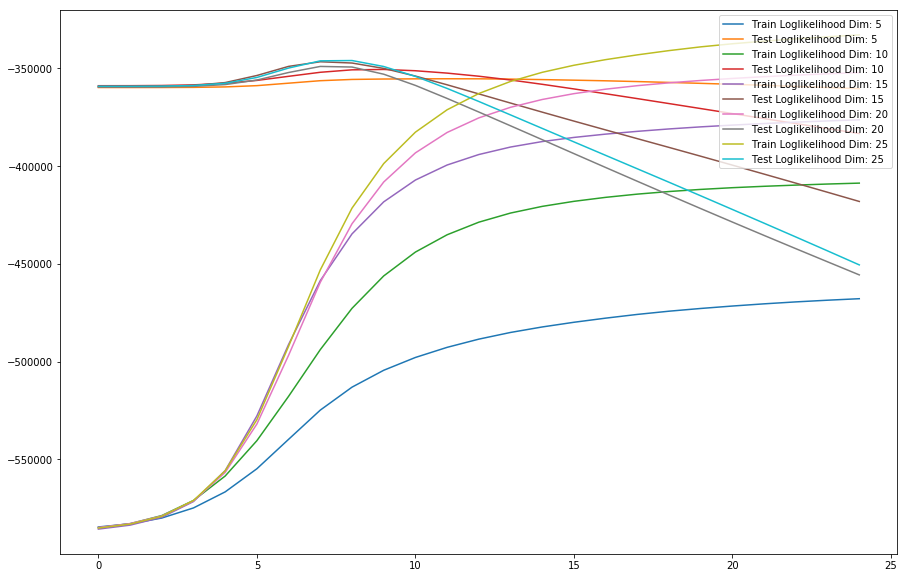

In [77]:
plt.figure(figsize=(15,10))
for i in range(len(dims)):
    train_label = "".join(["Train Loglikelihood ","Dim: ",str(dims[i])])
    test_label = "".join(["Test Loglikelihood ","Dim: ",str(dims[i])])

    plt.plot(train[i], label = train_label);
    
    plt.plot(test[i], label= test_label);
    
    
plt.legend(loc='upper right');

We see that, approximately, after iteration 7 the algorithm begins overfitting. The increase in training loglikelihood is very little, yet loglikelihood of the test set decreases significantly. Thus, we can apply **early stop** to prevent this. We are going to continue our training with 25 dimensions and we will early stop the algorithm at $7^{th}-8^{th}$ iteration.

### Training

After selecting the hidden dimensions as **25**, we are going to train our model with respect to entire set.

In [60]:
%%capture
factorization = NMF(ratings,25,8)
W,H,train_loss,test_loss = factorization.train(ratings,0.15)

We stopped the algorithm just at the correct spot. When test likelihood is on its peak (even though it is a small peak).

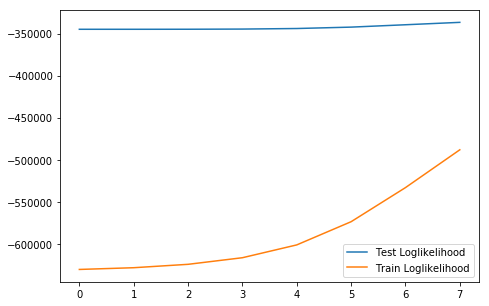

In [68]:
plt.figure(figsize=(7.5,5))
plt.plot(test_loss,label = "Test Loglikelihood");
plt.plot(train_loss,label = "Train Loglikelihood");
plt.legend(loc='lower right');

Until now, everything we did was based on mathematics. Yet, one should also make cognitive evaluation. In this regard, we are going to select a movie and look at movies that are close by with respect to our **reference movie**. 

In [62]:
database = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
database = database.pivot(index = "userId",columns ="movieId",values ="rating" )

The movie we are going to pick is "Star Wars: Episode V - The Empire Strikes Back (1980)". We are going to look at first **20** closest neighbors.

In [63]:
selected_movie = "Star Wars: Episode IV - A New Hope (1977)"
neighbors = 20

movie_id = movies[movies["title"] == selected_movie]["movieId"].values[0]
movie_list = list(database.columns)
index = movie_list.index(movie_id)
movie_vector = H[:,index]
difference = H - movie_vector.reshape(-1,1)
distance = np.sum(np.multiply(difference,difference),axis = 0)
selected_movies = np.argsort(distance)[:neighbors]
ids = pd.DataFrame(list( movie_list[i] for i in selected_movies ))

We see that the results make a lot of sense.

In [65]:
print("20 most similar movies with respect to",selected_movie, "are:")
print("(The calculations are made with respect to the distance between movie vectors)")
ids.merge(movies,left_on = 0, right_on = "movieId")[:]

20 most similar movies with respect to Star Wars: Episode IV - A New Hope (1977) are:
(The calculations are made with respect to the distance between movie vectors)


,0,movieId,title,genres
0,260,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1,1198,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
2,1196,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
3,1210,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
4,858,858,"Godfather, The (1972)",Crime|Drama
5,1270,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi
6,608,608,Fargo (1996),Comedy|Crime|Drama|Thriller
7,2028,2028,Saving Private Ryan (1998),Action|Drama|War
8,7153,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
9,2959,2959,Fight Club (1999),Action|Crime|Drama|Thriller


We see that the most similar movies to "Star Wars: Episode IV - A New Hope (1977)" are:
    
    - Raiders of the Lost Ark
    - Star Wars: Episode V - The Empire Strikes Back
    - Star Wars: Episode V - The Empire Strikes Back
    - Godfather, The 
    - Back to the Future 
    
We also see movies like: 
    - Fight Club 
    - Matrix, The 
    - Lord of the Rings: The Return of the King
    - Lord of the Rings: The Fellowship of the Ring
etc.

Thus, the list makes perfect intuitive sense.

In this homework

- We derived the update rules for NMF 
- Converted ratings into count data (even though from loss function point of view it was not necessary since the $V_{ij}!$ were removed, but it still is better practice due to our Poisson assumption)
- Wrote train-test split within the algoritm 
- Did hyper-parameter optimization 
- Monitored both training and test loglikelihood and applied early stop

At the end, we trained our model with selected hyper-parameters, did early stop and looked at our results to see if they make intuitive sense.

## Problem 2

After my first proposal at HW1, I have seen that Prof. Blei has already done the same work (except he added a Gaussian error term called offset to items vector) at "Collaborative Topic Modeling for Recommending Scientific Articles" (Wang and Blei, 2011) - http://www.cse.cuhk.edu.hk/irwin.king.new/_media/presentations/wangblei2011.pdf- .   

Thus, I decided to work on word disambigation project Griffin Adams. 


### Abstract

State of art word embedding models are good at learning the high dimensional representation of a word by mapping it into a vector-space using nearby words that are in the text. Yet, those models are not adequate for revealing the latent meaning of a word. For such models, the word "cell" is a word that can represent anything ranging from the organism (biology), prison (security) and phone (communication). Even though written the same, the word "cell" that is used in the context of biology differs from communication. In this study, we are going to propose a method to abbreviate this disambiguation in the context of clinical texts and distinguish homonyms.  Our proposal relies on Gaussian word embeddings to uncover the contextualized senses of the words through the posterior Skip gram distribution.  We extend the paper by Brazinskas et al to incorporate multiple modes to directly capture acronyms expansion in clinical text.  We train and evaluate our model on discharge note summaries (from Columbia and the publicly available MIMIC dataset), and find that it captures multiple senses better than any published model to date.